In [1]:
import pandas as pd
import numpy as np
from pathlib import Path

# paths
DATA = "../data/processed/cicids_processed.csv"
OUT_FIG = Path("../outputs/figures"); OUT_FIG.mkdir(parents=True, exist_ok=True)
OUT_MET = Path("../outputs/metrics"); OUT_MET.mkdir(parents=True, exist_ok=True)

# load
df = pd.read_csv(DATA)

# keep numeric features only for clustering
X = df.select_dtypes(include=[np.number]).copy()

# drop the target if present (unsupervised)
X = X.drop(columns=["is_attack"], errors="ignore")

# basic cleaning for clustering
X = X.replace([np.inf, -np.inf], np.nan)
X = X.fillna(X.median())

print("Data for clustering:", X.shape)

Data for clustering: (1048575, 52)


In [2]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
Xs = scaler.fit_transform(X)   # ndarray

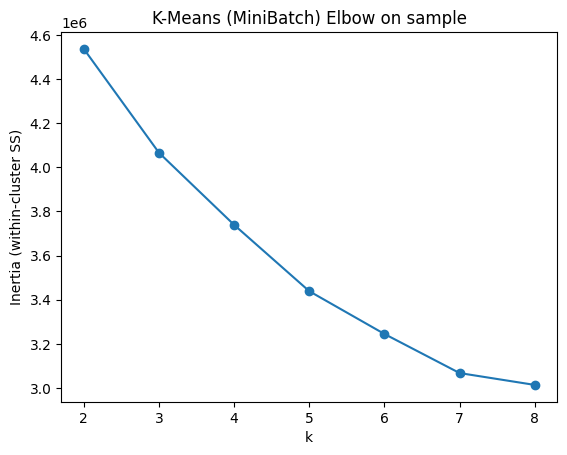

K-Means (MiniBatch, k=3) silhouette on 20000 samples: 0.279


In [3]:
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from sklearn.cluster import MiniBatchKMeans
from sklearn.metrics import silhouette_score

# Paths (ensure OUT_FIG exists)
OUT_FIG = Path("../outputs/figures"); OUT_FIG.mkdir(parents=True, exist_ok=True)

rng = np.random.RandomState(42)
elbow_n = min(100_000, Xs.shape[0])        
elbow_idx = rng.choice(Xs.shape[0], size=elbow_n, replace=False)
Xs_elbow = Xs[elbow_idx]

inertias = []
K = range(2, 9)                              
for k in K:
    km = MiniBatchKMeans(
        n_clusters=k, batch_size=2048, n_init=5, max_iter=100, random_state=42
    )
    km.fit(Xs_elbow)
    inertias.append(km.inertia_)

plt.plot(list(K), inertias, marker="o")
plt.xlabel("k"); plt.ylabel("Inertia (within-cluster SS)")
plt.title("K-Means (MiniBatch) Elbow on sample")
plt.savefig(OUT_FIG / "kmeans_elbow.png", bbox_inches="tight")
plt.show()

k = 3  

km_full = MiniBatchKMeans(
    n_clusters=k, batch_size=4096, n_init=5, max_iter=100, random_state=42
)
km_full.fit(Xs)

# labels for all points
labels_km = km_full.predict(Xs)

sil_n = min(20_000, Xs.shape[0])
sil_idx = rng.choice(Xs.shape[0], size=sil_n, replace=False)

if len(set(labels_km)) > 1: 
    sil_km = silhouette_score(Xs[sil_idx], labels_km[sil_idx])
    print(f"K-Means (MiniBatch, k={k}) silhouette on {sil_n} samples:", round(sil_km, 3))
else:
    print("Silhouette not defined: only one cluster label predicted.")

Explained variance (PC1, PC2): [0.21178761 0.1539266 ]


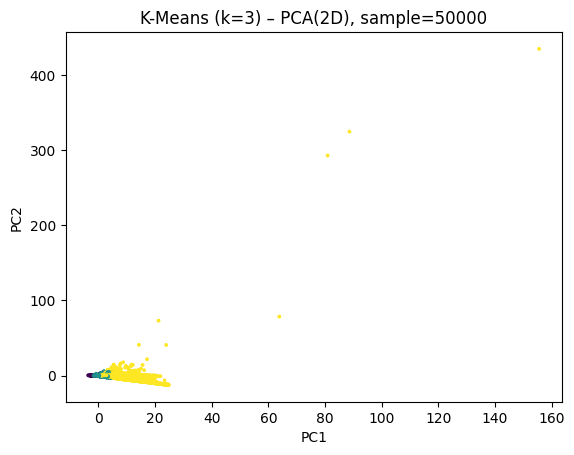

In [4]:
from sklearn.decomposition import PCA
import numpy as np
import matplotlib.pyplot as plt

# sample for visualization only
vis_n = min(50_000, Xs.shape[0])
rng = np.random.RandomState(42)
vis_idx = rng.choice(Xs.shape[0], size=vis_n, replace=False)

Xs_vis = Xs[vis_idx]
labels_km_vis = labels_km[vis_idx]  

pca = PCA(n_components=2, random_state=42)
Xp_vis = pca.fit_transform(Xs_vis)
print("Explained variance (PC1, PC2):", pca.explained_variance_ratio_[:2])

plt.scatter(Xp_vis[:, 0], Xp_vis[:, 1], c=labels_km_vis.astype(int), s=3)
plt.xlabel("PC1"); plt.ylabel("PC2")
plt.title(f"K-Means (k={k}) – PCA(2D), sample={vis_n}")
plt.savefig(OUT_FIG / f"kmeans_pca2_k{k}_sample{vis_n}.png", bbox_inches="tight")
plt.show()

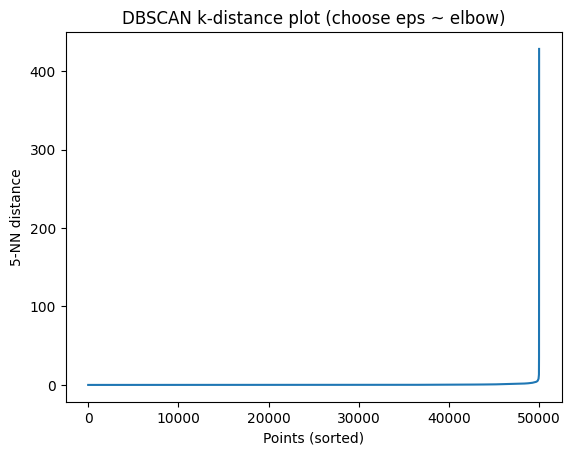

Suggested eps (95th percentile): ~1.309
Explained variance (PC1, PC2): [0.21178761 0.1539266 ]


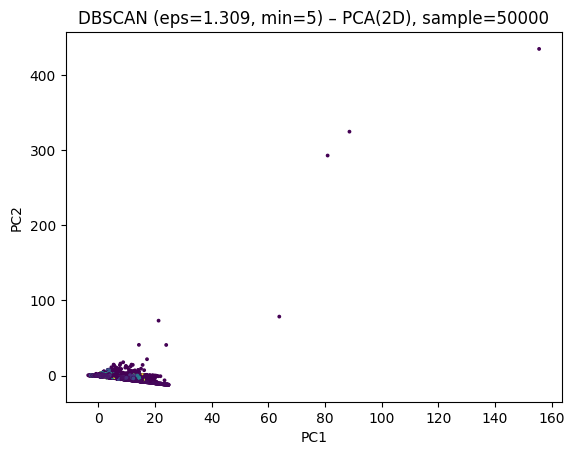

DBSCAN clusters: [np.int64(0), np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5), np.int64(6), np.int64(7), np.int64(8), np.int64(9), np.int64(10), np.int64(11), np.int64(12), np.int64(13), np.int64(14), np.int64(15), np.int64(16), np.int64(17), np.int64(18), np.int64(19), np.int64(20), np.int64(21), np.int64(22), np.int64(23), np.int64(24), np.int64(25), np.int64(26), np.int64(27), np.int64(28), np.int64(29), np.int64(30), np.int64(31), np.int64(32), np.int64(33), np.int64(34), np.int64(35), np.int64(36), np.int64(37), np.int64(38), np.int64(39), np.int64(40), np.int64(41), np.int64(42), np.int64(43), np.int64(44), np.int64(45), np.int64(46), np.int64(47), np.int64(48), np.int64(49), np.int64(50), np.int64(51), np.int64(52), np.int64(53), np.int64(54), np.int64(55), np.int64(56), np.int64(57), np.int64(58), np.int64(59), np.int64(60), np.int64(61), np.int64(62), np.int64(63), np.int64(64), np.int64(65), np.int64(66), np.int64(67), np.int64(68), np.int64(69), np.int64(70)

{'eps': 1.30898645336102,
 'min_samples': 5,
 'sample_size': 50000,
 'num_clusters_ex_noise': 149,
 'noise_points': 2030,
 'silhouette': 0.08631765294910841}

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
import pandas as pd

rng = np.random.RandomState(42)
db_n = min(50_000, Xs.shape[0])        
db_idx = rng.choice(Xs.shape[0], size=db_n, replace=False)
Xs_db = Xs[db_idx]
df_db = df.iloc[db_idx].copy()

min_samples = 5
nbrs = NearestNeighbors(n_neighbors=min_samples).fit(Xs_db)
dists, _ = nbrs.kneighbors(Xs_db)
k_d = np.sort(dists[:, -1])

plt.plot(k_d)
plt.xlabel("Points (sorted)")
plt.ylabel(f"{min_samples}-NN distance")
plt.title("DBSCAN k-distance plot (choose eps ~ elbow)")
plt.savefig(OUT_FIG / "dbscan_kdistance_sample.png", bbox_inches="tight")
plt.show()

suggested_eps = float(np.percentile(k_d, 95))
print(f"Suggested eps (95th percentile): ~{suggested_eps:.3f}")

eps = suggested_eps  
db = DBSCAN(eps=eps, min_samples=min_samples).fit(Xs_db)
labels_db = db.labels_

from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

pca = PCA(n_components=2, random_state=42)
Xp_db = pca.fit_transform(Xs_db)
print("Explained variance (PC1, PC2):", pca.explained_variance_ratio_[:2])

plt.scatter(Xp_db[:, 0], Xp_db[:, 1], c=labels_db.astype(int), s=3)
plt.xlabel("PC1"); plt.ylabel("PC2")
plt.title(f"DBSCAN (eps={eps:.3f}, min={min_samples}) – PCA(2D), sample={db_n}")
plt.savefig(OUT_FIG / f"dbscan_pca2_eps{eps:.3f}_min{min_samples}_sample{db_n}.png", bbox_inches="tight")
plt.show()


clusters = sorted(list(set(labels_db) - {-1}))
n_noise = int(np.sum(labels_db == -1))
print("DBSCAN clusters:", clusters, "| noise points:", n_noise, f"of {db_n}")

if len(clusters) >= 2:
    sil_db = silhouette_score(Xs_db, labels_db)
    print(f"[Silhouette] DBSCAN (eps={eps:.3f}, min={min_samples}) on {db_n} samples:", round(sil_db, 3))
else:
    sil_db = np.nan
    print("[Silhouette] Not defined (need >=2 clusters excluding noise).")

df_prof = df_db.copy()
df_prof["dbscan_cluster"] = labels_db
if "is_attack" in df_prof.columns:
    prof_db = df_prof.groupby("dbscan_cluster")["is_attack"].agg(["count", "mean"]).rename(columns={"mean":"attack_rate"})
    print("\nDBSCAN cluster profile (sample):\n", prof_db.sort_index())
    prof_db.to_csv(OUT_MET / f"dbscan_cluster_profile_eps{eps:.3f}_min{min_samples}_sample{db_n}.csv")

summary_db = {
    "eps": float(eps),
    "min_samples": int(min_samples),
    "sample_size": int(db_n),
    "num_clusters_ex_noise": int(len(clusters)),
    "noise_points": n_noise,
    "silhouette": None if np.isnan(sil_db) else float(sil_db)
}
summary_db

In [6]:
# labels back to original df for profiling
df_prof = df.copy()
df_prof["kmeans_cluster"] = labels_km
df_prof["dbscan_cluster"] = labels_db if len(labels_db)==len(df_prof) else -1  # safety

if "is_attack" in df.columns:
    # KMeans
    prof_km = df_prof.groupby("kmeans_cluster")["is_attack"].agg(["count","mean"]).rename(columns={"mean":"attack_rate"})
    # DBSCAN
    prof_db = df_prof.groupby("dbscan_cluster")["is_attack"].agg(["count","mean"]).rename(columns={"mean":"attack_rate"})
    print("\nK-Means cluster profile (count, attack_rate):\n", prof_km.sort_index())
    print("\nDBSCAN cluster profile (count, attack_rate):\n", prof_db.sort_index())
    prof_km.to_csv(OUT_MET / "kmeans_cluster_profile.csv")
    prof_db.to_csv(OUT_MET / "dbscan_cluster_profile.csv")

#summary metrics
summary = {
    "kmeans": {"k": int(k), "silhouette": None if np.isnan(sil_km) else float(sil_km)},
    "dbscan": {"eps": float(eps), "min_samples": int(min_samples),
               "silhouette": None if np.isnan(sil_db) else float(sil_db),
               "noise_points": int(n_noise)}
}
pd.Series(summary).to_json(OUT_MET / "clustering_summary.json")
summary



K-Means cluster profile (count, attack_rate):
                  count  attack_rate
kmeans_cluster                     
0               153285     0.024138
1               740173     0.197946
2               155117     0.514367

DBSCAN cluster profile (count, attack_rate):
                   count  attack_rate
dbscan_cluster                      
-1              1048575     0.219346


{'kmeans': {'k': 3, 'silhouette': 0.27851480056499334},
 'dbscan': {'eps': 1.30898645336102,
  'min_samples': 5,
  'silhouette': 0.08631765294910841,
  'noise_points': 2030}}